## Programming Exercise 8: Anomaly Detection and Recommender Systems

In [219]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #Use for fmincg

### 1 Anomaly detection

In [220]:
datafile = 'data/ex8data1.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']

Ycv = mat['yval']
Xcv = mat['Xval']

In [221]:
# Visualize the data
def plotData(myX, newFig=False):
    if newFig:
        plt.figure(figsize=(8,6))
    plt.plot(myX[:,0],myX[:,1],'b+')
    plt.xlabel('Latency [ms]',fontsize=16)
    plt.ylabel('Throughput [mb/s]',fontsize=16)
    plt.grid(True)

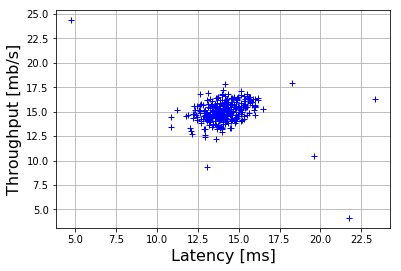

In [222]:
plotData(X)

#### 1.1 Gaussian distribution

In [223]:
def gaus(myX, mymu, mysig2):
    """
    Function to compute the gaussian return values of a feature
    matrix, myX, given the already computed mu vector and sigma matrix.
    
    If sigma is a vector, it is turned into a diagonal对角线 matrix
    Uses a loop over rows
    
    P(x; mu, sigma^2 ) = ...
    """
    m = myX.shape[0] # No. of samples
    n = myX.shape[1] # No. of features
    
    if np.ndim(mysig2) == 1:
        mysig2 = np.diag(mysig2)
        
    #           (2*pi)^(n/2)
    norm = 1./(np.power((2*np.pi), n/2) * np.sqrt(np.linalg.det(mysig2)))
    myinv = np.linalg.inv(mysig2)
    myexp = np.zeros((m, 1))
    for irow in range(m):
        xrow = myX[irow]
        myexp[irow] = np.exp(-0.5*((xrow-mymu).T).dot(myinv).dot(xrow-mymu))
    return norm * myexp
    

#### 1.2 Estimating parameters for a Gaussian

In [224]:
def getGaussianParams(myX, useMultivariate=True):
    """
    Function that given a feature matrix X that is (m x n)
    returns a mean vector and a sigmaSquared vector that are 
    both (n x 1) in shape
    
    This can do it either as 1D gaussian for each feature,
    or as a multivariate多元 gaussian
    
    μi, σi^2
    """
    
    m = myX.shape[0]
    mu = np.mean(myX, axis=0)
    if not useMultivariate:
        # not multivariate
        sigma2 = np.sum(np.square(myX-mu), axis=0)/float(m)
        return mu, sigma2
    else:
        # multivariate
        sigma2 = ((myX-mu).T.dot(myX-mu))/float(m)
        return mu, sigma2
    

In [225]:
mu, sig2 = getGaussianParams(X, useMultivariate=True)

##### 1.2.1 Visualizing the Gaussain probability contours

In [226]:
def plotContour(mymu, mysigma2, newFig=False, useMultivariate=True):
    delta = .5
    myX = np.arange(0, 30, delta)
    myY = np.arange(0, 30, delta)
    meshX, meshY = np.meshgrid(myX, myY)
    
    coord_list = [entry.ravel() for entry in (meshX, meshY)] # => [[myX], [myY]
    points = np.vstack(coord_list).T # => [[x1, y1], [x2, y2], ...]
    
    myZ = gaus(points, mymu, mysigma2)
    myZ = myZ.reshape((myX.shape[0], myX.shape[0]))
    
    if newFig: plt.figure(figsize=(6,4))
        
    cont_levels = [10**exp for exp in range(-20, 0 ,3)]
    print (cont_levels)
    mycont = plt.contour(meshX, meshY, myZ, levels=cont_levels)
    
    plt.title('Gaussian Contours',fontsize=16)    
    

[1e-20, 1e-17, 1e-14, 1e-11, 1e-08, 1e-05, 0.01]
[1e-20, 1e-17, 1e-14, 1e-11, 1e-08, 1e-05, 0.01]


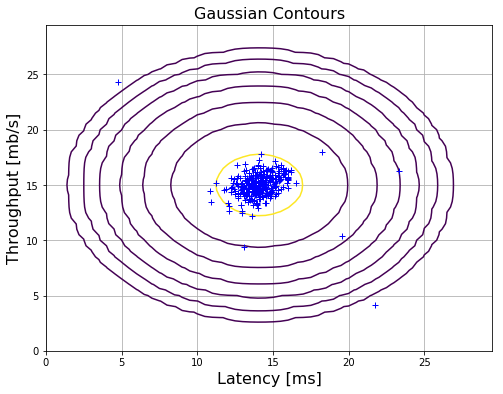

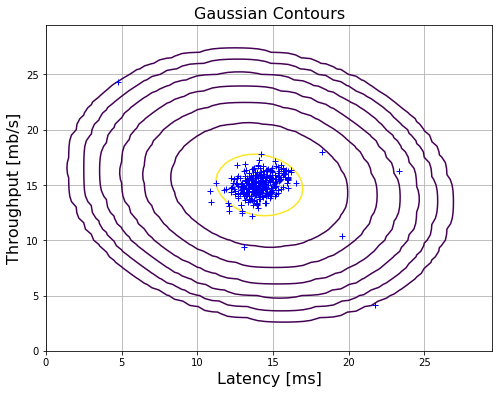

In [227]:
# First contours without using multivariate gaussian:
plotData(X, newFig=True)
useMV = False # whether using multivariate gaussian
plotContour(*getGaussianParams(X, useMV), newFig=False, useMultivariate=useMV)

# Then contours with multivariate gaussian:
plotData(X, newFig=True)
useMV = True # whether using multivariate gaussian
plotContour(*getGaussianParams(X, useMV), newFig=False, useMultivariate=useMV)



####  Selecting the threshold 阀值,  $\epsilon$

In [228]:
def computeF1(predVec, trueVec):
    """
    F1 = 2 * (P*R)/(P+R)
    where P is precision, R is recall
    
    Precision = "of all predicted y=1, what fraction分数 had true y=1"
    Recall = "of all predicted y=1, what fraction prediced y=0"
    
    Note predictionVec and trueLabelVec should be boolean vectors.
    """
    
    P, R = 0., 0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0]) \
                    if predVec[x]]) / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0]) \
                    if trueVec[x]]) / float(np.sum(trueVec))
    if (P+R) != 0:
        return 2*P*R/(P+R) 
    else: 
        return 0
    

In [250]:
def selectThreshold(myycv, mypCVs):
    """
    Function to select the best epsilon value from the CV set
    by looping over possible epsilon values and computing the F1
    score for each
    """
    
    # Make a list of possible epsilon values
    nsteps = 1000
    epses = np.linspace(np.min(mypCVs), np.max(mypCVs), nsteps)
    
    # Compute the F1 score for each epsilon value, and store the best
    # F1 score (and corresponding best epsilon)
    bestF1, bestEps = 0, 0
    trueVec = (myycv == 1).flatten() # trueVec [False , False, True, ....., False]
    for eps in epses:
        predVec = mypCVs < eps # predVec [False , False, True, ....., False]
        thisF1 = computeF1(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
            
    print ("Best F1 is %f, best eps is %0.4g."%(bestF1,bestEps))
    return bestF1, bestEps
    

In [251]:
# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaus(Xcv, mu, sig2)

# Ycv = 0 or 1
#You should see a value for epsilon of about 8.99e-05.
bestF1, bestEps = selectThreshold(Ycv, pCVs)

Best F1 is 0.875000, best eps is 9.075e-05.


In [102]:
# 绘制异常数据
def plotAnomalies(myX, mybestEps, newFig=False, useMultivariate=True):
    ps = gaus(myX, *getGaussianParams(myX, useMultivariate))
    anoms = np.array([myX[x] for x in range (myX.shape[0]) if ps[x] < mybestEps])
    if newFig: plt.figure(figsize=(6,4))
    plt.scatter(anoms[:,0], anoms[:,1], s=80, facecolors='none', edgecolors='r')
    

[1e-20, 1e-17, 1e-14, 1e-11, 1e-08, 1e-05, 0.01]


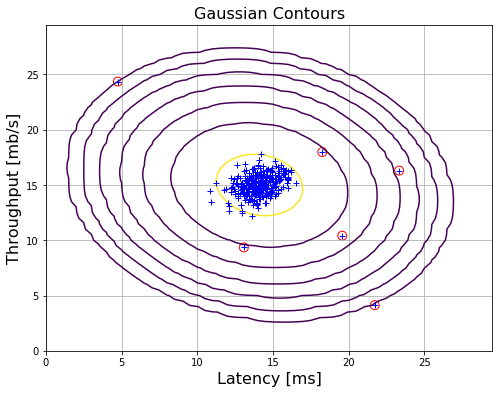

In [103]:
plotData(X, newFig=True)
plotContour(mu, sig2, newFig=False, useMultivariate=True)
plotAnomalies(X, bestEps, newFig=False, useMultivariate=True)

#### 1.4 High dimensinal dataset

In [104]:
datafile = 'data/ex8data2.mat'
mat = scipy.io.loadmat( datafile )
Xpart2 = mat['X']
# cross validation set
Ycvpart2 = mat['yval']
Xcvpart2 = mat['Xval']
print ('Xpart2 shape is ', Xpart2.shape)

Xpart2 shape is  (1000, 11)


In [110]:
mu, sig2 = getGaussianParams(Xpart2, useMultivariate=False)
ps = gaus(Xpart2, mu, sig2)
# psCV = gaus(Xcvpart2, mu, sig2)
# print (psCV)

# Using the gaussian parameters from the full training set
# figure out the p-value for each point in the CV set
pCVs = gaus(Xcvpart2, mu, sig2)
# print (pCVs)

# You should see a value epsilon of about 1.38e-18, and 117 anomalies found.
bestF1, bestEps = selectThreshold(Ycvpart2, pCVs)
anoms = [Xpart2[x] for x in range(Xpart2.shape[0]) if ps[x] < bestEps]
print ('# of anomalies found: ',len(anoms))


Best F1 is 0.615385, best eps is 1.379e-18.
# of anomalies found:  117


### Recommender Systems

#### 2.1 Movie ratings dataset

In [112]:
datafile = 'data/ex8_movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']

nm, nu = Y.shape
# Y is 1682x943 containing ratings (1-5) of 1682 movies on 943 users
# and rating of 0 means the movie wasn't rated
# R is 1682x943 containing R(i,j) = 1 if user j gave a rating to movie i


Average rating for movie 1 (Toy Story): 3.88


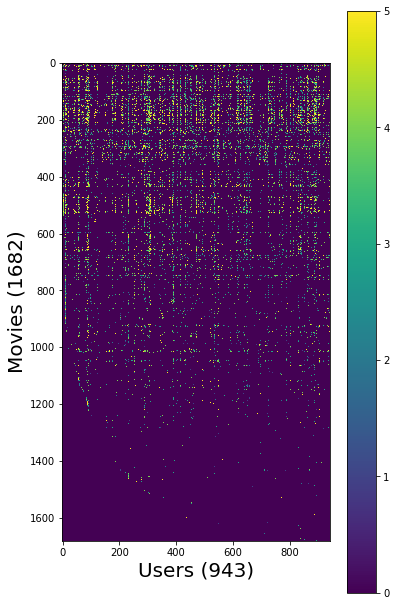

In [113]:
print ('Average rating for movie 1 (Toy Story): %0.2f' % \
    np.mean([ Y[0][x] for x in range(Y.shape[1]) if R[0][x] ]))

# Visualize the ratings matrix
fig = plt.figure(figsize=(6,6*(1682./943.)))
dummy = plt.imshow(Y)
dummy = plt.colorbar()
dummy = plt.ylabel('Movies (%d)'%nm,fontsize=20)
dummy = plt.xlabel('Users (%d)'%nu,fontsize=20)


In [ ]:
# Throughout this part of the exercise, you will also be 
# working with the matrices, X and Theta
# The i-th row of X corresponds to the feature vector x(i) for the i-th movie, 
# and the j-th row of Theta corresponds to one parameter vector θ(j), for the j-th user. 
# Both x(i) and θ(j) are n-dimensional vectors. For the purposes of this exercise, 
# you will use n = 100, and therefore, x(i) ∈ R100 and θ(j) ∈ R100. Correspondingly, 
# X is a nm × 100 matrix and Theta is a nu × 100 matrix.

#### 2.2 Collabrative filtering learning algorithm

In [116]:
# Read in the movie params matrices
datafile = 'data/ex8_movieParams.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']
Theta = mat['Theta']
nu = int(mat['num_users'])
nm = int(mat['num_movies'])
nf = int(mat['num_features'])

# For now, reduce the data set size so that this runs faster
nu = 4; nm = 5; nf = 3
X = X[:nm,:nf] # rows: 0-5, cols: 0-3 -> 5x3
Theta = Theta[:nu,:nf] # 4x3
Y = Y[:nm,:nu] # 5x4
R = R[:nm,:nu] # 5x4
"""
r(i,j)=1 if user j has rated movie i(if identified) (0 otherwise)
y(i,j) = rating by user j on movie i
ø(j) = parameter vector for user j => 相当于每个user对每种类型（feature）的movie喜欢程度
x(i) = feature vector for movie i => 相当于表述一个movie中每个feature的占有率
for user j , movie i, prediced rating: (ø(i)).T.dot(X(i))

m(j) = no. of movies rated by user j
"""

(4, 3) (5, 4) (5, 4)


In [118]:
# The "parameters" we are minimizing are both the element of the 
# X matrix (nm*nf => 5x3) and of the Theta matrix (nu*nf => 4x3)
# To use off-the-shelf现成的 minimizers we need to flatten these matrices
# into one long array
def flattenParams(myX, myTheta):
    """
    Hand this fucntion an X matrix and a Theta matrix and it will flatten
    it into one long (nm*nf + nu*nf, 1) shaped numpy array
    """
    return np.concatenate((myX.flatten(), myTheta.flatten()))


In [125]:
# A utility通用的 function to re-shape the X and Theta will probably come in handy方便的
def reshapeParams(flattened_XandTheta, mynm, mynu, mynf):
    assert flattened_XandTheta.shape[0] == int(nm*nf+nu*nf)

    # 将原来平铺的X+Theta =》 X and Theta two matrices
    reX = flattened_XandTheta[:int(mynm*mynf)].reshape((mynm, mynf))
    reTheta = flattened_XandTheta[int(mynm*mynf):].reshape((mynu, mynf))
    
    return reX, reTheta


##### 2.2.1 Collaborative filtering cost function and 2.2.3 Regularized cost function

In [123]:
# Collaborative filtering cost function 
# J(x(1), ...., x(nm), ø(1), ..., ø(nu))
def cofiCostFunc(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    
    # Unfold展开 the X and Theta matrices from the flattened params
    myX, myTheta = reshapeParams(myparams, mynm, mynu, mynf)
    
    # Note: 
    # X Shape is (nm x nf), Theta shape is (nu x nf), Y and R shape is (nm x nu)
    # Behold注意! Complete vectorization向量化
    
    # First dot theta and x together such that you get a matrix the same shape as Y
    term1 = myX.dot(myTheta.T)
    
    # Then element-wise mutiply that matrix by the R matrix
    # so only terms from movies whtch that user rated are counted in the cost
    term1 = np.multiply(term1, myR)
    
    # Then substract减去 the Y-matrix (which has 0 entries for non-rated)
    # movies by each user, so no need to multiply that by myR...
    # though , if a user could rate a movie "0 starts" then myY would have to be
    # element-wise multiplied by myR as well)
    # also square that whole term, sum all elements in the resulting matrix,
    # and multiply by 0.5 to get the cost
    cost = 0.5 * np.sum(np.square(term1-myY))
    
    # Regularization stuff
    cost += (mylambda/2.) * np.sum(np.square(myTheta))
    cost += (mylambda/2.) * np.sum(np.square(myX))
    
    return cost
    

In [126]:
# "...run your cost function. You should expect to see an output of 22.22."
print ('Cost with nu = 4, nm = 5, nf = 3 is %0.2f.' % \
    cofiCostFunc(flattenParams(X,Theta),Y,R,nu,nm,nf))
    
# "...with lambda = 1.5 you should expect to see an output of 31.34."
print ('Cost with nu = 4, nm = 5, nf = 3 (and lambda = 1.5) is %0.2f.' % \
    cofiCostFunc(flattenParams(X,Theta),Y,R,nu,nm,nf,mylambda=1.5))

Cost with nu = 4, nm = 5, nf = 3 is 22.22.
Cost with nu = 4, nm = 5, nf = 3 (and lambda = 1.5) is 31.34.


##### 2.2.2 Collaborative filtering gradient and 2.2.4 Regularized gradient

In [127]:
# Remember: use the exact same input arguments使用完全相同的参数 for gradient function
# as for the cost function (the off-the-shelf现成的 minimizer requireds this)

# Collaborative filtering gradient 协同过滤梯度
def cofiGrad(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    
    # Unfold the X and Theta matrices from the flattened params
    myX, myTheta = reshapeParams(myparams, mynm, mynu, mynf)

    # First the X gradient term
    # First dot theta and x together such that you get a matrix the shape as Y
    term1 = myX.dot(myTheta.T)
    
    # Then multiply this term by myR to remove any components from movies that
    # weren't rated by that user
    term1 = np.multiply(term1, myR)
    
    # Now substract减去 the Y matrix (which already has 0 for nonrated movies)
    term1 -= myY
    
    # Lastly dot this with Theta such that the resulting matrix has the
    # the same shape as the X matrix
    Xgrad = term1.dot(myTheta)
    
    # Now the Theta gradient term (reusing the "term1" variable)
    Thetagrad = term1.T.dot(myX)
    
    # Regularization stuff
    Xgrad += mylambda * myX
    Thetagrad += mylambda * myTheta
    
    return flattenParams(Xgrad, Thetagrad)


In [131]:
# Let's check my gradient computation real quick:

def checkGradient(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):

    print ('Numerical Gradient \t cofiGrad \t\t Difference')
    
    # Compute a numerical gradient with an epsilon perturbation vector扰动矢量
    myeps = 0.0001
    nparams = len(myparams)
    epsvec = np.zeros(nparams)
    
    # These are my implemented gradient solution
    mygrads = cofiGrad(myparams,myY,myR,mynu,mynm,mynf,mylambda)
    
    # Choose 10 random elements of my combined (X, Theta) param vector
    # and compute the numerical gradient for each... print to screen
    # the numerical gradient next to mu cofiGradient
    
    for i in range(10):
        idx = np.random.randint(0, nparams)
        epsvec[idx] = myeps
        loss1 = cofiCostFunc(myparams-epsvec,myY,myR,mynu,mynm,mynf,mylambda)
        loss2 = cofiCostFunc(myparams+epsvec,myY,myR,mynu,mynm,mynf,mylambda)    
        
        mygrad = (loss2 - loss1) / (2*myeps)
        
        epsvec[idx] = 0
        
        print ('%0.15f \t %0.15f \t %0.15f' % \
        (mygrad, mygrads[idx],mygrad - mygrads[idx]))
    


In [133]:
print ("Checking gradient with lambda = 0...")
checkGradient(flattenParams(X,Theta),Y,R,nu,nm,nf)
print ("\nChecking gradient with lambda = 1.5...")
checkGradient(flattenParams(X,Theta),Y,R,nu,nm,nf,mylambda = 1.5)


Checking gradient with lambda = 0...
Numerical Gradient 	 cofiGrad 		 Difference
-0.803780061460202 	 -0.803780061452057 	 -0.000000000008145
-1.899790261372658 	 -1.899790261386604 	 0.000000000013946
4.627760190007990 	 4.627760190006159 	 0.000000000001831
2.263336983929776 	 2.263336983921972 	 0.000000000007804
2.263336983929776 	 2.263336983921972 	 0.000000000007804
-1.899790261372658 	 -1.899790261386604 	 0.000000000013946
-0.803780061460202 	 -0.803780061452057 	 -0.000000000008145
0.000000000000000 	 0.000000000000000 	 0.000000000000000
3.352650312855587 	 3.352650312849549 	 0.000000000006038
1.164413669449971 	 1.164413669446225 	 0.000000000003746

Checking gradient with lambda = 1.5...
Numerical Gradient 	 cofiGrad 		 Difference
-6.765636277386022 	 -6.765636277366185 	 -0.000000000019837
-0.407840857938879 	 -0.407840857935279 	 -0.000000000003600
-0.718206734191540 	 -0.718206734196469 	 0.000000000004929
0.602526771817935 	 0.602526771833594 	 -0.000000000015659
4.08

#### 2.3 Learning movie recommendations

##### 2.3.1 Recommendations

In [158]:
# So, this file has the list of movies and their respection index in the Y vector
# Let's make a list of strings to reference later
movies = []
with open('data/movie_ids.txt', encoding='ISO-8859-1') as f:
    lines = f.readlines()
    for line in lines:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))


In [160]:
# Rather than rate some movies myself, I'll use what was built-in to the homework
my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [159]:
# I'll read in the data because I shortened them eariler (to debug)
datafile = 'data/ex8_movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']
# We'll use 10 features
nf = 10



In [162]:
# Add my ratings to the Y matrix, and the relevant相关的 row to the R matrix
myR_row = my_ratings > 0
Y = np.hstack((Y, my_ratings))
R = np.hstack((R, myR_row))

# nm -> no. of the movies
# nu -> no. of the users
nm, nu = Y.shape


In [164]:
def normalizeRatings(myY, myR):
    """
    Preprocess data by substracting减去 mean rating for every movie (every row)

    This is important because without this, a user who hasn't rated any movies
    will have a predicted score of 0 for every movie, while in reality
    they should have a predicted score of [average score of that moive]
    未做评分的电影（对一个用户来说）将其设置为该电影的平均分
    """
    
    # The mean is only counting movies that were rated 
    Ymean = np.sum(myY, axis=1) / np.sum(myR, axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0], 1))
        
    return myY-Ymean, Ymean
    

In [176]:
Ynorm, Ymean = normalizeRatings(Y, R)

In [170]:
# Generate random initial parameters, Thetas and X
X = np.random.rand(nm, nf) # matrix nm x nf => 1682 x 10
Theta = np.random.rand(nu, nf)
myflatten = flattenParams(X, Theta)

# Regularization parameter of 10 is used (as used in the homework assignment)
mylambda = 10.

# Training the actual model with fmin_cg
result = scipy.optimize.fmin_cg(cofiCostFunc, x0=myflatten, fprime=cofiGrad, \
                                args=(Y, R, nu, nm, nf, mylambda), \
                                maxiter=50, disp=True, full_output=True)



         Current function value: 72963.551100
         Iterations: 50
         Function evaluations: 77
         Gradient evaluations: 77


In [181]:
# Reshape the trainded output into sensible合乎情理的 "X" and "Theta" mareices
# result[0] => flattened_XandTheta
resX, resTheta = reshapeParams(result[0], nm, nu, nf)


(array([0.78574462, 0.56460704, 0.42790385, ..., 0.66055171, 0.62571547,
       0.43973591]), 72963.55110020058, 77, 77, 1)


In [172]:
# After training the model, now make recommendations by computing
# the predictions matrix
prediction_matrix = resX.dot(resTheta.T)

In [184]:
# Grab the last user's predictions (since I put my prediction at the
# the end of Y matrix, not the front)
# Add back in the mean ratings
my_predictions = prediction_matrix[:, -1] + Ymean.flatten()


In [189]:
# Sort my_predictions from highest to lowest
# np.argsort(x) 对x内进行排序(从大到小)，返回排序后的x在未排序前的index
pred_idxs_sorted = np.argsort(my_predictions)

# [::-1] -> 取从最后一个元素到第一个元素
# [:] -> 所有元素
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]


[1545 1570 1578 ...  317  312   63]
[  63  312  317 ... 1578 1570 1545]


In [179]:
print ("Top recommendations for you:")

for i in range(10):
    print ('Predicting rating %0.1f for movie %s.' % \
    (my_predictions[pred_idxs_sorted[i]],movies[pred_idxs_sorted[i]]))
    
print ("\nOriginal ratings provided:")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print ('Rated %d for movie %s.' % (my_ratings[i],movies[i]))


Top recommendations for you:
Predicting rating 8.3 for movie Shawshank Redemption, The (1994).
Predicting rating 8.3 for movie Titanic (1997).
Predicting rating 8.2 for movie Schindler's List (1993).
Predicting rating 8.2 for movie Raiders of the Lost Ark (1981).
Predicting rating 8.2 for movie Star Wars (1977).
Predicting rating 8.1 for movie Good Will Hunting (1997).
Predicting rating 8.0 for movie Usual Suspects, The (1995).
Predicting rating 8.0 for movie Braveheart (1995).
Predicting rating 8.0 for movie Wrong Trousers, The (1993).
Predicting rating 7.9 for movie Godfather, The (1972).

Original ratings provided:
Rated 4 for movie Toy Story (1995).
Rated 3 for movie Twelve Monkeys (1995).
Rated 5 for movie Usual Suspects, The (1995).
Rated 4 for movie Outbreak (1995).
Rated 5 for movie Shawshank Redemption, The (1994).
Rated 3 for movie While You Were Sleeping (1995).
Rated 5 for movie Forrest Gump (1994).
Rated 2 for movie Silence of the Lambs, The (1991).
Rated 4 for movie Alien

In [191]:
a = np.array([1,2,3,4,5])
print (a[:])
print (a[::-1])

[1 2 3 4 5]
[5 4 3 2 1]


In [212]:
t_x = np.array([1,2,3,4])
t_y = np.array([4,5,6,7])
f_x, f_y = np.meshgrid(t_x, t_y)

elist = [entry.ravel() for entry in (t_x, t_y)]
print (elist)

ep = np.vstack(elist).T
print (ep)

print ([t_x, t_y])

[array([1, 2, 3, 4]), array([4, 5, 6, 7])]
[[1 4]
 [2 5]
 [3 6]
 [4 7]]
[array([1, 2, 3, 4]), array([4, 5, 6, 7])]


In [204]:
cont_levels = [10**exp for exp in range(0, 20 ,3)]
print (cont_levels)

[1, 1000, 1000000, 1000000000, 1000000000000, 1000000000000000, 1000000000000000000]
